# Задание 1

In [1]:
import numpy as np
import scipy.integrate as spi
import scipy.stats as sps
import seaborn as sns

In [2]:
def generate_vector():
    x = np.random.uniform(-1, 1, 5)
    y = np.random.normal(2 + 3*x[0] - 2*x[1] + x[2] + x[3] - x[4], 1.5, 1)[0]
    x = np.append(x, y)
    return x

In [3]:
sample = np.array([generate_vector() for _ in range(50)])

Берем следующий базис: $\{1, x_1, x_2, x_3, x_4, x_5\}$

$$R^2 = \frac{TSS - RSS}{TSS}$$

$$RSS = e^Te$$

$$TSS = \sum{(y_i - \overline{y})^2}$$

In [4]:
def linear_regression(Y_I, Y):
    F = Y_I.T @ Y_I
    F_inv = np.linalg.inv(F)
    B = F_inv @ Y_I.T @ Y
    e = Y - Y_I @ B
    RSS = e.T @ e
    TSS = np.sum((Y - np.average(Y)) ** 2)
    R_2 = (TSS - RSS) / TSS
    return [F, F_inv, B, e, RSS, TSS, R_2]

## Проверка на мультиколлинеарность

In [5]:
Y_I = np.array([np.append(np.array([1]), el[:5]) for el in sample])
Y = sample[:, 5]

In [6]:
for i in range(1, 6):
    Y_I_temp = np.delete(Y_I, i, 1)
    Y_temp = Y_I[:, i]

    _, _, _, _, _, _, R_2_temp = linear_regression(Y_I_temp, Y_temp)
    print(f"R^2 для фактора {i}: {R_2_temp}")
    if R_2_temp >= 0.7:
        print(f"Фактор {i} сильно коррелирует с остальными")
    else:
        print(f"Фактор {i} не сильно коррелирует с остальными")

R^2 для фактора 1: 0.07814837559658484
Фактор 1 не сильно коррелирует с остальными
R^2 для фактора 2: 0.12433042655678803
Фактор 2 не сильно коррелирует с остальными
R^2 для фактора 3: 0.1136757919184232
Фактор 3 не сильно коррелирует с остальными
R^2 для фактора 4: 0.10824635974148972
Фактор 4 не сильно коррелирует с остальными
R^2 для фактора 5: 0.044274216127506386
Фактор 5 не сильно коррелирует с остальными


## Уравнение регрессии

In [7]:
F, F_inv, B, e, RSS, TSS, R_2 = linear_regression(Y_I, Y)
print(f"Коэффициенты линейной регрессии: {B}")
print(f'RSS регрессии: {RSS}')
print(f'TTS регрессии: {TSS}')

Коэффициенты линейной регрессии: [ 2.31146429  3.18400582 -1.90749773  0.92144176  0.70922087 -1.16289769]
RSS регрессии: 119.67569078816881
TTS регрессии: 465.66069854639034


## Коэффициент детерминации и его значимость

In [8]:
delta = R_2 / (1 - R_2) * (50 - 6) / (6 - 1)
p_value = spi.quad(sps.f.pdf, delta, np.inf, args=(6 - 1, 50 - 6))[0]
if p_value < 0.05:
    print('Регрессия значима')
else:
    print('Регрессия не значима')

Регрессия значима


## Значение в точке 0 и доверительный интервал

In [9]:
x_0 = np.array([1, 0, 0, 0, 0, 0])
y_0 = B @ x_0

kappa = np.sqrt(1 + x_0 @ F_inv @ x_0.T)
quantile = sps.t.pdf(0.975, 50 - 6)
value = kappa * np.sqrt(RSS) / np.sqrt(50 - 6)
left_border = y_0 - quantile * value
right_border = y_0 + quantile * value
print(f'Значение в точке 0: {y_0}')
print(f'Доверительный интервал для значения в точке 0: [{left_border}, {right_border}]')

Значение в точке 0: 2.3114642864687
Доверительный интервал для значения в точке 0: [1.901821651037332, 2.7211069219000676]


## Независимость ошибок

In [10]:
errors = []
for y in Y:
    errors.append(y - B[0] - B[1:] @ Y_I[0][1:])

invs = 0
for i in range(len(errors) - 1):
    for j in range(i + 1, len(errors)):
        if errors[j] < errors[i]:
            invs += 1

delta = (invs - 50 * (50 - 1) / 4) / np.sqrt(50 ** 3 / 36)
p_value = spi.quad(sps.norm.pdf, np.abs(delta), np.inf)[0] * 2
print(p_value, delta)
print(f"Ошибке распределены{(' не' if p_value < 0.05 else '')} независимо")

0.2663222771769011 -1.1115718600252527
Ошибке распределены независимо


## Нормальность распределения ошибок

## Исследование регрессии на выбросы

<Axes: >

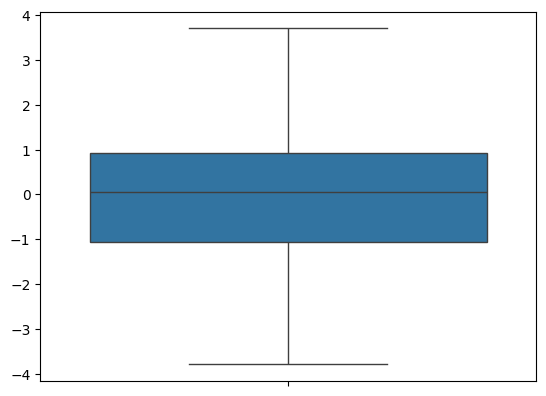

In [11]:
sns.boxplot(data=e)

In [12]:
min_i = np.where(e == np.min(e))[0][0]
max_i = np.where(e == np.max(e))[0][0]

Y_I_n = np.delete(Y_I, [min_i, max_i], 0)
Y_n = np.delete(Y, [min_i, max_i], 0)
_, _, B_n, _, RSS_n, TSS_n, R_2_n =  linear_regression(Y_I_n, Y_n)
print(f"Коэффициенты регрессии: {B_n}")
print(f"RSS регрессии: {RSS_n}")
print(f"TSS регрессии: {TSS_n}")
print(f"Коэффициент детерминации регрессии: {R_2_n}")

delta = R_2_n / (1 - R_2_n) * (48 - 6) / (6 - 1)
p_value = spi.quad(sps.f.pdf, delta, np.inf, args=(4 - 1, 48 - 6))[0]
if p_value < 0.05:
    print('Регрессия значима')
else:
    print('Регрессия не значима')

Коэффициенты регрессии: [ 2.2011559   2.84780119 -1.85844047  1.07784613  1.09794957 -1.07906557]
RSS регрессии: 87.76351938223746
TSS регрессии: 431.27992774697907
Коэффициент детерминации регрессии: 0.7965045119518613
Регрессия значима


## Кросс-проверка регрессии

In [13]:
CVSS = []
for i in range(50):
    Y_I_t = np.delete(Y_I, i, 0)
    Y_t = np.delete(Y, i, 0)
    _, _, B, *_ = linear_regression(Y_I_t, Y_t)

    y_i = Y_I[i]
    y = y_i @ B
    CVSS.append((Y[i] - y) ** 2)

TSS = np.sum((Y - np.average(Y)) ** 2)
cvss = np.sum(CVSS)
print(f"CVSS регрессии: {cvss}")
print(f"R^2_cvss регрессии: {(TSS - cvss) / TSS}")

CVSS регрессии: 155.22776739948486
R^2_cvss регрессии: 0.6666504863218113


## Адекватность регрессии

In [14]:
x = [np.random.uniform(-1, 1) for _ in range(5)]
y = [np.random.normal(2 + 3*x[0] - 2*x[1] + x[2] + x[3] - x[4], 1.5, 1)[0] for _ in range(5)]

S_2 = np.sum((y - np.average(y)) ** 2) / 4
delta = RSS / (50 - 6) / S_2
p_value = 1 - spi.quad(sps.f.pdf, delta, np.inf, args=(50 - 6, 4))[0]
print(f'Регрессия{" не" if p_value < 0.05 else ""} адекватна')

Регрессия адекватна


## Удаление переменной

In [15]:
B_s = [(B - np.min(B)) / (np.max(B) - np.min(B))]
index_b_min = np.where(B_s == np.min(B_s))[1][0]
Y_I_s = np.delete(Y_I, index_b_min, 1)

F_s = Y_I_s.T @ Y_I_s
F_inv_s = np.linalg.inv(F_s)

B_s = F_inv_s @ Y_I_s.T @ Y
e_s = Y - Y_I_s @ B_s
RSS_s = e_s.T @ e_s
TSS_s = np.sum((Y - np.average(Y_I_s @ B_s)) ** 2)
R_2_s = (TSS_s - RSS_s) / TSS_s

print(f"Коэффициенты регрессии: {B_s}")
print(f"RSS регрессии: {RSS_s}")
print(f"TSS регрессии: {TSS_s}")
print(f"Коэффициент детерминации регрессии: {R_2_s}")

delta = R_2_s / (1 - R_2_s) * (50 - 5) / (5 - 1)
p_value = spi.quad(sps.f.pdf, delta, np.inf, args=(5 - 1, 50 - 5))[0]
if p_value < 0.05:
    print('Регрессия значима')
else:
    print('Регрессия не значима')

Коэффициенты регрессии: [ 2.55197763  3.34687809  1.3657685   1.19051252 -1.08544132]
RSS регрессии: 190.3566246804569
TSS регрессии: 465.66069854639034
Коэффициент детерминации регрессии: 0.5912117443566196
Регрессия значима


## Сравнение регрессии и Bootstrap

In [16]:
delta = (RSS_s - RSS) / RSS * (50 - 6)
p_value = 1 - sps.f.cdf(np.abs(delta), 44, 1)
print(p_value)

0.15461716647529622


In [17]:
b_deltas = []
N = 1000

for _ in range(N):
    b_indexes = np.random.choice(50, size=50)
    b_x = Y_I_s[b_indexes]
    b_y = Y[b_indexes]

    _, _, _, _, RSS_b, TSS_b, _ = linear_regression(b_x, b_y)
    b_deltas.append((RSS_b - RSS) / RSS * (50 - 6) / (6 - 5))

b_deltas = np.sort(b_deltas)
p_value = np.sum(delta < b_deltas) / len(b_deltas)
print(p_value)

0.262
